#TODO
pridat timer aj pri embeddingu, fixnut LLM loopm, hodit do funkcii a prec z ntb do .py suboru tie loopy 

In [1]:
import os

os.chdir("../")
print(os.getcwd())

c:\Users\risko\Desktop\Prompt-Classification


In [2]:
import pickle
import random
import statistics
import time

import numpy as np
import onnxruntime as ort
import pandas as pd
import torch
from dotenv import load_dotenv
from fastembed import TextEmbedding
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from tqdm import tqdm
from xgboost import XGBClassifier

from prompt_classifier.metrics import evaluate
from prompt_classifier.modeling.dspy_gpt import GPT4oMini
from prompt_classifier.modeling.fasttext import FastTextClassifier
from prompt_classifier.modeling.nli_modernbert import ModernBERTNLI

load_dotenv()
random.seed(42)

c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
providers = ort.get_available_providers()

print(providers)

['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']


In [4]:
law_prompts = pd.read_csv("data/processed/law_prompts.csv")
general_prompts = pd.read_csv("data/processed/general_prompts.csv")
healthcare_prompts = pd.read_csv("data/processed/healthcare_prompts.csv")
finance_prompts = pd.read_csv("data/processed/finance_prompts.csv")

law_dataset = (
    pd.concat([law_prompts, general_prompts]).sample(frac=1).reset_index(drop=True)
)
healthcare_dataset = (
    pd.concat([healthcare_prompts, general_prompts])
    .sample(frac=1)
    .reset_index(drop=True)
)
finance_dataset = (
    pd.concat([finance_prompts, general_prompts]).sample(frac=1).reset_index(drop=True)
)

datasets = {
    "law": law_dataset,
    "healthcare": healthcare_dataset,
    "finance": finance_dataset,
}

In [5]:
law_prompts_interim = pd.read_csv("data/interim/law_prompts.csv")
general_prompts_interim = pd.read_csv("data/interim/general_prompts.csv")
healthcare_prompts_interim = pd.read_csv("data/interim/healthcare_prompts.csv")
finance_prompts_interim = pd.read_csv("data/interim/finance_prompts.csv")

law_dataset_interim = (
    pd.concat([law_prompts_interim, general_prompts_interim])
    .sample(frac=1)
    .reset_index(drop=True)
)
healthcare_dataset_interim = (
    pd.concat([healthcare_prompts_interim, general_prompts_interim])
    .sample(frac=1)
    .reset_index(drop=True)
)
finance_dataset_interim = (
    pd.concat([finance_prompts_interim, general_prompts_interim])
    .sample(frac=1)
    .reset_index(drop=True)
)

datasets_interim = {
    "law": law_dataset_interim,
    "healthcare": healthcare_dataset_interim,
    "finance": finance_dataset_interim,
}

In [6]:
baai_embedding = TextEmbedding(
    model_name="BAAI/bge-small-en-v1.5", providers=["CUDAExecutionProvider"]
)
mini_embedding = TextEmbedding(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    providers=["CUDAExecutionProvider"],
)

tfidf_embedding = TfidfVectorizer()

embedding_models = {
    "mini": mini_embedding,
    "tfidf": tfidf_embedding,
    "baai": baai_embedding,
}

In [7]:
print(f"BAAI-BGE available providers: {baai_embedding.model.model.get_providers()}")
print(f"MiniLM available providers: {mini_embedding.model.model.get_providers()}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch._dynamo.config.suppress_errors = True # Suppresses warnings in ModernBERT

BAAI-BGE available providers: ['CUDAExecutionProvider', 'CPUExecutionProvider']
MiniLM available providers: ['CUDAExecutionProvider', 'CPUExecutionProvider']
Using device: cuda


# GPT and ModernBERT loop using interim data

Going to sample between 1 and 8 traces per predictor.
Will attempt to bootstrap 4 candidate sets.
  0%|          | 0/22 [00:00<?, ?it/s]

23:59:12 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 1.00 / 1 (100.0%):   5%|▍         | 1/22 [00:00<00:13,  1.58it/s]

23:59:12 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 2.00 / 2 (100.0%):   5%|▍         | 1/22 [00:00<00:13,  1.58it/s]

23:59:12 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 3.00 / 3 (100.0%):  14%|█▎        | 3/22 [00:01<00:06,  2.94it/s]

23:59:12 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 4.00 / 4 (100.0%):  14%|█▎        | 3/22 [00:01<00:06,  2.94it/s]

23:59:12 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 5.00 / 5 (100.0%):  18%|█▊        | 4/22 [00:01<00:06,  2.94it/s]

23:59:12 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 6.00 / 6 (100.0%):  27%|██▋       | 6/22 [00:01<00:03,  5.21it/s]

23:59:12 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 7.00 / 7 (100.0%):  27%|██▋       | 6/22 [00:01<00:03,  5.21it/s]

23:59:12 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 8.00 / 8 (100.0%):  32%|███▏      | 7/22 [00:01<00:02,  5.21it/s]

23:59:12 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?
23:59:12 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cach

Average Metric: 10.00 / 10 (100.0%):  41%|████      | 9/22 [00:01<00:01,  8.47it/s]

23:59:12 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 11.00 / 11 (100.0%):  45%|████▌     | 10/22 [00:01<00:01,  8.47it/s]

23:59:13 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 12.00 / 12 (100.0%):  55%|█████▍    | 12/22 [00:01<00:01,  9.81it/s]

23:59:13 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 13.00 / 13 (100.0%):  55%|█████▍    | 12/22 [00:01<00:01,  9.81it/s]

23:59:13 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 14.00 / 14 (100.0%):  64%|██████▎   | 14/22 [00:01<00:00, 10.40it/s]

23:59:13 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 15.00 / 15 (100.0%):  64%|██████▎   | 14/22 [00:01<00:00, 10.40it/s]

23:59:13 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 16.00 / 16 (100.0%):  73%|███████▎  | 16/22 [00:02<00:00,  8.66it/s]

23:59:13 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 17.00 / 17 (100.0%):  73%|███████▎  | 16/22 [00:02<00:00,  8.66it/s]

23:59:13 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 18.00 / 18 (100.0%):  82%|████████▏ | 18/22 [00:02<00:00,  7.88it/s]

23:59:13 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 19.00 / 19 (100.0%):  82%|████████▏ | 18/22 [00:02<00:00,  7.88it/s]

23:59:14 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 20.00 / 20 (100.0%):  91%|█████████ | 20/22 [00:02<00:00,  8.77it/s]

23:59:14 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 21.00 / 21 (100.0%):  91%|█████████ | 20/22 [00:03<00:00,  8.77it/s]

23:59:14 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\llms\openai\openai.py", line 726, in completion
    raise e
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\llms\openai\openai.py", line 653, in completion
    self.make_sync_openai_chat_completion_request(
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\litellm_core_utils\logging_utils.py", line 145, in sync_wrapper
    result = func(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\llms\openai\openai.py", line 472, in make_sync_openai_chat_completion_request
    raise e
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\li

Average Metric: 22.00 / 22 (100.0%): 100%|██████████| 22/22 [00:03<00:00,  6.80it/s]

2025/02/21 23:59:14 INFO dspy.evaluate.evaluate: Average Metric: 22 / 22 (100.0%)



New best score: 100.0 for seed -3
Scores so far: [100.0]
Best score so far: 100.0
  0%|          | 0/22 [00:00<?, ?it/s]

23:59:15 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 1.00 / 1 (100.0%):   5%|▍         | 1/22 [00:00<00:07,  2.64it/s]

23:59:15 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 2.00 / 2 (100.0%):   5%|▍         | 1/22 [00:00<00:07,  2.64it/s]

23:59:15 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 3.00 / 3 (100.0%):  14%|█▎        | 3/22 [00:00<00:03,  5.85it/s]

23:59:15 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 4.00 / 4 (100.0%):  14%|█▎        | 3/22 [00:00<00:03,  5.85it/s]

23:59:15 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 5.00 / 5 (100.0%):  23%|██▎       | 5/22 [00:00<00:01,  8.72it/s]

23:59:15 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 6.00 / 6 (100.0%):  23%|██▎       | 5/22 [00:00<00:01,  8.72it/s]

23:59:15 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 7.00 / 7 (100.0%):  32%|███▏      | 7/22 [00:01<00:01,  7.54it/s]

23:59:15 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 8.00 / 8 (100.0%):  36%|███▋      | 8/22 [00:01<00:01,  7.09it/s]

23:59:16 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 9.00 / 9 (100.0%):  41%|████      | 9/22 [00:01<00:02,  6.35it/s]

23:59:16 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 10.00 / 10 (100.0%):  45%|████▌     | 10/22 [00:01<00:01,  7.02it/s]

23:59:16 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 11.00 / 11 (100.0%):  45%|████▌     | 10/22 [00:01<00:01,  7.02it/s]

23:59:16 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 12.00 / 12 (100.0%):  55%|█████▍    | 12/22 [00:01<00:01,  7.47it/s]

23:59:16 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 13.00 / 13 (100.0%):  59%|█████▉    | 13/22 [00:01<00:01,  6.47it/s]

23:59:16 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 14.00 / 14 (100.0%):  64%|██████▎   | 14/22 [00:02<00:01,  6.17it/s]

23:59:16 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 15.00 / 15 (100.0%):  68%|██████▊   | 15/22 [00:02<00:01,  6.64it/s]

23:59:16 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 16.00 / 16 (100.0%):  68%|██████▊   | 15/22 [00:02<00:01,  6.64it/s]

23:59:17 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 17.00 / 17 (100.0%):  77%|███████▋  | 17/22 [00:02<00:00,  9.28it/s]

23:59:17 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 18.00 / 18 (100.0%):  77%|███████▋  | 17/22 [00:02<00:00,  9.28it/s]

23:59:17 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 19.00 / 19 (100.0%):  86%|████████▋ | 19/22 [00:02<00:00,  7.74it/s]

23:59:17 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 20.00 / 20 (100.0%):  91%|█████████ | 20/22 [00:02<00:00,  8.07it/s]

23:59:17 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 21.00 / 21 (100.0%):  95%|█████████▌| 21/22 [00:02<00:00,  8.24it/s]

23:59:18 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 22.00 / 22 (100.0%): 100%|██████████| 22/22 [00:03<00:00,  6.03it/s]

2025/02/21 23:59:18 INFO dspy.evaluate.evaluate: Average Metric: 22 / 22 (100.0%)



Scores so far: [100.0, 100.0]
Best score so far: 100.0


  0%|          | 0/22 [00:00<?, ?it/s]23:59:18 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?
 36%|███▋      | 

Bootstrapped 8 full traces after 8 examples for up to 1 rounds, amounting to 8 attempts.
  0%|          | 0/22 [00:00<?, ?it/s]

23:59:19 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 1.00 / 1 (100.0%):   5%|▍         | 1/22 [00:00<00:11,  1.81it/s]

23:59:19 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 2.00 / 2 (100.0%):   9%|▉         | 2/22 [00:00<00:08,  2.39it/s]

23:59:19 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 3.00 / 3 (100.0%):   9%|▉         | 2/22 [00:00<00:08,  2.39it/s]

23:59:19 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 4.00 / 4 (100.0%):  14%|█▎        | 3/22 [00:00<00:07,  2.39it/s]

23:59:19 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 5.00 / 5 (100.0%):  23%|██▎       | 5/22 [00:01<00:03,  5.26it/s]

23:59:19 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 6.00 / 6 (100.0%):  23%|██▎       | 5/22 [00:01<00:03,  5.26it/s]

23:59:20 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 7.00 / 7 (100.0%):  32%|███▏      | 7/22 [00:01<00:02,  7.06it/s]

23:59:20 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 8.00 / 8 (100.0%):  36%|███▋      | 8/22 [00:01<00:02,  6.17it/s]

23:59:20 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 9.00 / 9 (100.0%):  36%|███▋      | 8/22 [00:01<00:02,  6.17it/s]

23:59:20 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 10.00 / 10 (100.0%):  45%|████▌     | 10/22 [00:01<00:01,  6.00it/s]

23:59:20 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 11.00 / 11 (100.0%):  45%|████▌     | 10/22 [00:01<00:01,  6.00it/s]

23:59:20 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 12.00 / 12 (100.0%):  55%|█████▍    | 12/22 [00:02<00:01,  7.70it/s]

23:59:20 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 13.00 / 13 (100.0%):  59%|█████▉    | 13/22 [00:02<00:01,  7.40it/s]

23:59:20 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 14.00 / 14 (100.0%):  59%|█████▉    | 13/22 [00:02<00:01,  7.40it/s]

23:59:21 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 15.00 / 15 (100.0%):  64%|██████▎   | 14/22 [00:02<00:01,  7.40it/s]

23:59:21 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 16.00 / 16 (100.0%):  73%|███████▎  | 16/22 [00:02<00:00,  9.96it/s]

23:59:21 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 17.00 / 17 (100.0%):  73%|███████▎  | 16/22 [00:02<00:00,  9.96it/s]

23:59:21 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 18.00 / 18 (100.0%):  82%|████████▏ | 18/22 [00:03<00:00,  5.84it/s]

23:59:21 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 19.00 / 19 (100.0%):  82%|████████▏ | 18/22 [00:03<00:00,  5.84it/s]

23:59:22 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 20.00 / 20 (100.0%):  91%|█████████ | 20/22 [00:03<00:00,  6.24it/s]

23:59:23 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 21.00 / 21 (100.0%):  95%|█████████▌| 21/22 [00:04<00:00,  3.31it/s]

23:59:23 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 22.00 / 22 (100.0%): 100%|██████████| 22/22 [00:04<00:00,  4.99it/s]

2025/02/21 23:59:23 INFO dspy.evaluate.evaluate: Average Metric: 22 / 22 (100.0%)



Scores so far: [100.0, 100.0, 100.0]
Best score so far: 100.0


  0%|          | 0/22 [00:00<?, ?it/s]23:59:23 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?
  5%|▍         | 

Bootstrapped 7 full traces after 7 examples for up to 1 rounds, amounting to 7 attempts.
  0%|          | 0/22 [00:00<?, ?it/s]

23:59:31 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 1.00 / 1 (100.0%):   5%|▍         | 1/22 [00:00<00:13,  1.52it/s]

23:59:31 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 1.00 / 2 (50.0%):   5%|▍         | 1/22 [00:00<00:13,  1.52it/s] 

23:59:31 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 2.00 / 3 (66.7%):   9%|▉         | 2/22 [00:00<00:13,  1.52it/s]

23:59:31 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?
23:59:31 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cach

Average Metric: 4.00 / 5 (80.0%):  23%|██▎       | 5/22 [00:00<00:02,  8.03it/s]

23:59:32 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 5.00 / 6 (83.3%):  23%|██▎       | 5/22 [00:00<00:02,  8.03it/s]

23:59:32 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 6.00 / 7 (85.7%):  32%|███▏      | 7/22 [00:01<00:02,  6.12it/s]

23:59:32 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 7.00 / 8 (87.5%):  32%|███▏      | 7/22 [00:01<00:02,  6.12it/s]

23:59:32 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 8.00 / 9 (88.9%):  41%|████      | 9/22 [00:01<00:02,  5.33it/s]

23:59:32 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 9.00 / 10 (90.0%):  41%|████      | 9/22 [00:01<00:02,  5.33it/s]

23:59:32 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 10.00 / 11 (90.9%):  50%|█████     | 11/22 [00:01<00:01,  5.87it/s]

23:59:33 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 11.00 / 12 (91.7%):  55%|█████▍    | 12/22 [00:02<00:02,  4.14it/s]

23:59:33 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 12.00 / 13 (92.3%):  59%|█████▉    | 13/22 [00:02<00:01,  4.57it/s]

23:59:33 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 13.00 / 14 (92.9%):  59%|█████▉    | 13/22 [00:02<00:01,  4.57it/s]

23:59:33 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 14.00 / 15 (93.3%):  68%|██████▊   | 15/22 [00:02<00:01,  6.31it/s]

23:59:33 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 15.00 / 16 (93.8%):  68%|██████▊   | 15/22 [00:02<00:01,  6.31it/s]

23:59:34 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 16.00 / 17 (94.1%):  77%|███████▋  | 17/22 [00:02<00:00,  7.43it/s]

23:59:34 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 17.00 / 18 (94.4%):  77%|███████▋  | 17/22 [00:03<00:00,  7.43it/s]

23:59:34 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 18.00 / 19 (94.7%):  86%|████████▋ | 19/22 [00:03<00:00,  8.42it/s]

23:59:34 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 19.00 / 20 (95.0%):  86%|████████▋ | 19/22 [00:03<00:00,  8.42it/s]

23:59:34 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 20.00 / 21 (95.2%):  95%|█████████▌| 21/22 [00:03<00:00,  8.51it/s]

23:59:34 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 21.00 / 22 (95.5%): 100%|██████████| 22/22 [00:03<00:00,  6.18it/s]

2025/02/21 23:59:34 INFO dspy.evaluate.evaluate: Average Metric: 21 / 22 (95.5%)



Scores so far: [100.0, 100.0, 100.0, 95.45]
Best score so far: 100.0


  0%|          | 0/22 [00:00<?, ?it/s]23:59:34 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?
  5%|▍         | 

Bootstrapped 3 full traces after 3 examples for up to 1 rounds, amounting to 3 attempts.
  0%|          | 0/22 [00:00<?, ?it/s]

23:59:36 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 1.00 / 1 (100.0%):   5%|▍         | 1/22 [00:00<00:10,  2.07it/s]

23:59:36 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 2.00 / 2 (100.0%):   5%|▍         | 1/22 [00:00<00:10,  2.07it/s]

23:59:37 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 3.00 / 3 (100.0%):  14%|█▎        | 3/22 [00:00<00:05,  3.78it/s]

23:59:37 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 4.00 / 4 (100.0%):  14%|█▎        | 3/22 [00:00<00:05,  3.78it/s]

23:59:37 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 5.00 / 5 (100.0%):  18%|█▊        | 4/22 [00:00<00:04,  3.78it/s]

23:59:37 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 6.00 / 6 (100.0%):  27%|██▋       | 6/22 [00:00<00:02,  7.99it/s]

23:59:37 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 7.00 / 7 (100.0%):  27%|██▋       | 6/22 [00:01<00:02,  7.99it/s]

23:59:37 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 8.00 / 8 (100.0%):  36%|███▋      | 8/22 [00:01<00:01,  7.54it/s]

23:59:37 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 9.00 / 9 (100.0%):  36%|███▋      | 8/22 [00:01<00:01,  7.54it/s]

23:59:37 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 10.00 / 10 (100.0%):  45%|████▌     | 10/22 [00:01<00:01,  9.15it/s]

23:59:37 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 11.00 / 11 (100.0%):  45%|████▌     | 10/22 [00:01<00:01,  9.15it/s]

23:59:37 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 12.00 / 12 (100.0%):  55%|█████▍    | 12/22 [00:01<00:00, 10.43it/s]

23:59:37 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 13.00 / 13 (100.0%):  55%|█████▍    | 12/22 [00:01<00:00, 10.43it/s]

23:59:38 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 14.00 / 14 (100.0%):  64%|██████▎   | 14/22 [00:01<00:00,  9.11it/s]

23:59:38 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 15.00 / 15 (100.0%):  64%|██████▎   | 14/22 [00:02<00:00,  9.11it/s]

23:59:38 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 16.00 / 16 (100.0%):  68%|██████▊   | 15/22 [00:02<00:00,  9.11it/s]

23:59:38 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 17.00 / 17 (100.0%):  73%|███████▎  | 16/22 [00:02<00:00,  7.15it/s]

23:59:38 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 18.00 / 18 (100.0%):  77%|███████▋  | 17/22 [00:02<00:00,  7.15it/s]

23:59:38 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 19.00 / 19 (100.0%):  86%|████████▋ | 19/22 [00:02<00:00,  9.70it/s]

23:59:38 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 20.00 / 20 (100.0%):  86%|████████▋ | 19/22 [00:02<00:00,  9.70it/s]

23:59:39 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 21.00 / 21 (100.0%):  95%|█████████▌| 21/22 [00:03<00:00,  5.15it/s]

23:59:39 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 22.00 / 22 (100.0%): 100%|██████████| 22/22 [00:03<00:00,  6.76it/s]

2025/02/21 23:59:39 INFO dspy.evaluate.evaluate: Average Metric: 22 / 22 (100.0%)



Scores so far: [100.0, 100.0, 100.0, 95.45, 100.0]
Best score so far: 100.0


  0%|          | 0/22 [00:00<?, ?it/s]23:59:40 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?
  5%|▍         | 

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.
  0%|          | 0/22 [00:00<?, ?it/s]

23:59:40 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 1.00 / 1 (100.0%):   5%|▍         | 1/22 [00:00<00:11,  1.86it/s]

23:59:40 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 2.00 / 2 (100.0%):   5%|▍         | 1/22 [00:00<00:11,  1.86it/s]

23:59:41 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 3.00 / 3 (100.0%):   9%|▉         | 2/22 [00:00<00:10,  1.86it/s]

23:59:41 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 4.00 / 4 (100.0%):  18%|█▊        | 4/22 [00:00<00:02,  6.04it/s]

23:59:41 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 5.00 / 5 (100.0%):  18%|█▊        | 4/22 [00:00<00:02,  6.04it/s]

23:59:41 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 6.00 / 6 (100.0%):  27%|██▋       | 6/22 [00:01<00:03,  4.91it/s]

23:59:41 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 7.00 / 7 (100.0%):  32%|███▏      | 7/22 [00:01<00:03,  4.85it/s]

23:59:41 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 8.00 / 8 (100.0%):  32%|███▏      | 7/22 [00:01<00:03,  4.85it/s]

23:59:41 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 9.00 / 9 (100.0%):  36%|███▋      | 8/22 [00:01<00:02,  4.85it/s]

23:59:42 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 10.00 / 10 (100.0%):  45%|████▌     | 10/22 [00:01<00:01,  7.80it/s]

23:59:42 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 11.00 / 11 (100.0%):  45%|████▌     | 10/22 [00:01<00:01,  7.80it/s]

23:59:42 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 12.00 / 12 (100.0%):  55%|█████▍    | 12/22 [00:01<00:01,  7.23it/s]

23:59:42 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 13.00 / 13 (100.0%):  55%|█████▍    | 12/22 [00:01<00:01,  7.23it/s]

23:59:42 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 14.00 / 14 (100.0%):  64%|██████▎   | 14/22 [00:02<00:00,  8.17it/s]

23:59:42 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 15.00 / 15 (100.0%):  68%|██████▊   | 15/22 [00:02<00:00,  7.47it/s]

23:59:42 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 16.00 / 16 (100.0%):  68%|██████▊   | 15/22 [00:02<00:00,  7.47it/s]

23:59:42 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 17.00 / 17 (100.0%):  73%|███████▎  | 16/22 [00:02<00:00,  7.47it/s]

23:59:43 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 18.00 / 18 (100.0%):  82%|████████▏ | 18/22 [00:03<00:00,  5.25it/s]

23:59:43 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 19.00 / 19 (100.0%):  86%|████████▋ | 19/22 [00:03<00:00,  5.37it/s]

23:59:43 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 20.00 / 20 (100.0%):  91%|█████████ | 20/22 [00:03<00:00,  5.65it/s]

23:59:43 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 21.00 / 21 (100.0%):  91%|█████████ | 20/22 [00:03<00:00,  5.65it/s]

23:59:44 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 22.00 / 22 (100.0%): 100%|██████████| 22/22 [00:04<00:00,  5.45it/s]

2025/02/21 23:59:44 INFO dspy.evaluate.evaluate: Average Metric: 22 / 22 (100.0%)



Scores so far: [100.0, 100.0, 100.0, 95.45, 100.0, 100.0]
Best score so far: 100.0


  0%|          | 0/22 [00:00<?, ?it/s]23:59:45 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?
  5%|▍         | 

Bootstrapped 4 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.
  0%|          | 0/22 [00:00<?, ?it/s]

23:59:47 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 1.00 / 1 (100.0%):   0%|          | 0/22 [00:00<?, ?it/s]

23:59:48 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 2.00 / 2 (100.0%):   5%|▍         | 1/22 [00:00<00:06,  3.12it/s]

23:59:48 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 3.00 / 3 (100.0%):  14%|█▎        | 3/22 [00:00<00:03,  5.13it/s]

23:59:48 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 4.00 / 4 (100.0%):  14%|█▎        | 3/22 [00:00<00:03,  5.13it/s]

23:59:48 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 5.00 / 5 (100.0%):  18%|█▊        | 4/22 [00:00<00:03,  5.13it/s]

23:59:48 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 6.00 / 6 (100.0%):  23%|██▎       | 5/22 [00:00<00:02,  6.69it/s]

23:59:48 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 7.00 / 7 (100.0%):  32%|███▏      | 7/22 [00:01<00:02,  6.30it/s]

23:59:49 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 8.00 / 8 (100.0%):  36%|███▋      | 8/22 [00:01<00:02,  4.89it/s]

23:59:49 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 9.00 / 9 (100.0%):  36%|███▋      | 8/22 [00:01<00:02,  4.89it/s]

23:59:49 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 10.00 / 10 (100.0%):  45%|████▌     | 10/22 [00:01<00:02,  5.60it/s]

23:59:49 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 11.00 / 11 (100.0%):  45%|████▌     | 10/22 [00:01<00:02,  5.60it/s]

23:59:49 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 12.00 / 12 (100.0%):  55%|█████▍    | 12/22 [00:02<00:01,  5.38it/s]

23:59:50 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 13.00 / 13 (100.0%):  59%|█████▉    | 13/22 [00:02<00:01,  5.15it/s]

23:59:50 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 14.00 / 14 (100.0%):  64%|██████▎   | 14/22 [00:02<00:01,  5.61it/s]

23:59:50 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 15.00 / 15 (100.0%):  68%|██████▊   | 15/22 [00:02<00:01,  5.34it/s]

23:59:50 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 16.00 / 16 (100.0%):  73%|███████▎  | 16/22 [00:02<00:01,  5.41it/s]

23:59:50 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 17.00 / 17 (100.0%):  77%|███████▋  | 17/22 [00:03<00:00,  5.26it/s]

23:59:50 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 18.00 / 18 (100.0%):  77%|███████▋  | 17/22 [00:03<00:00,  5.26it/s]

23:59:50 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?
23:59:50 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cach

Average Metric: 20.00 / 20 (100.0%):  86%|████████▋ | 19/22 [00:03<00:00,  7.01it/s]

23:59:51 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\llms\openai\openai.py", line 726, in completion
    raise e
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\llms\openai\openai.py", line 653, in completion
    self.make_sync_openai_chat_completion_request(
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\litellm_core_utils\logging_utils.py", line 145, in sync_wrapper
    result = func(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\llms\openai\openai.py", line 472, in make_sync_openai_chat_completion_request
    raise e
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\li

Average Metric: 21.00 / 21 (100.0%):  95%|█████████▌| 21/22 [00:04<00:00,  4.37it/s]

23:59:53 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?


Average Metric: 22.00 / 22 (100.0%): 100%|██████████| 22/22 [00:05<00:00,  3.93it/s]

2025/02/21 23:59:53 INFO dspy.evaluate.evaluate: Average Metric: 22 / 22 (100.0%)



Scores so far: [100.0, 100.0, 100.0, 95.45, 100.0, 100.0, 100.0]
Best score so far: 100.0
7 candidate programs found.


  0%|          | 0/100 [00:00<?, ?it/s]23:59:53 - LiteLLM:ERROR: caching.py:645 - LiteLLM Cache: Excepton add_cache: no such column: "size" - should this be a string literal in single-quotes?
Traceback (most recent call last):
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\caching.py", line 643, in add_cache
    self.cache.set_cache(cache_key, cached_data, **kwargs)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\litellm\caching\disk_cache.py", line 28, in set_cache
    self.disk_cache.set(key, value)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 808, in set
    self._row_insert(db_key, raw, now, columns)
  File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\diskcache\core.py", line 857, in _row_insert
    sql(
sqlite3.OperationalError: no such column: "size" - should this be a string literal in single-quotes?
  1%|          |

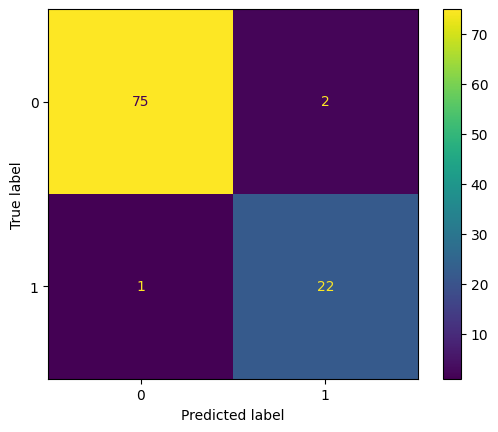

Device set to use cuda:0
  0%|          | 0/100 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
W0222 00:01:09.939000 10580 site-packages\torch\_dynamo\convert_frame.py:1233] WON'T CONVERT compiled_embeddings c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\transformers\models\modernbert\modeling_modernbert.py line 206 
W0222 00:01:09.939000 10580 site-packages\torch\_dynamo\convert_frame.py:1233] due to: 
W0222 00:01:09.939000 10580 site-packages\torch\_dynamo\convert_frame.py:1233] Traceback (most recent call last):
W0222 00:01:09.939000 10580 site-packages\torch\_dynamo\convert_frame.py:1233]   File "c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\torch\_dynamo\convert_frame.py", line 1164, in __call__
W0222 00:01:09.939000 10580 site-packages\torch\_dynamo\convert_frame.py:1233]     result = self._inner_convert(
W0222 00:01:09.939

ValueError: Classification metrics can't handle a mix of binary and unknown targets

In [ ]:
for domain, dataset in datasets_interim.items():
    # Split data
    train_data = dataset.sample(frac=0.00025)
    test_data = dataset.drop(train_data.index).head(100)

    # GPT Classifier
    gpt_classifier = GPT4oMini(
        api_key=os.getenv("OPENAI_API_KEY"),
        proxy_url=os.getenv("PROXY_URL"),
        model_name="gpt-4o-mini",
        domain=domain,
        train_data=train_data,
        test_data=test_data,
    )

    # DSPy optimization
    gpt_classifier.optimize_model()

    # Get predictions and metrics for test data
    test_predictions, test_actuals, test_latency = gpt_classifier.predict()

    test_predictions = [int(pred) for pred in test_predictions]
    test_actuals = [int(actual) for actual in test_actuals]
    test_acc = metrics.accuracy_score(test_actuals, test_predictions)

    # Evaluate and save model
    evaluate(
        predictions=test_predictions,
        true_labels=test_actuals,
        domain=domain,
        model_name="gpt4o-mini",
        embed_model="ada-002",
        cost=gpt_classifier.cost,
        latency=test_latency,
        train_acc=test_acc
    )

    gpt_classifier.save_model(f"models/gpt-4o-mini-{domain}.json")

    # ModernBERT Classifier
    bert_classifier = ModernBERTNLI(domain=domain)

    # Test predictions
    test_predictions = []
    test_times = []
    for _, row in tqdm(test_data.iterrows(), total=len(test_data)):
        start_time = time.perf_counter_ns()
        pred = bert_classifier.predict(row["prompt"])
        test_predictions.append(pred)
        test_times.append(time.perf_counter_ns() - start_time)

    test_acc = metrics.accuracy_score(test_data["label"], test_predictions)
    mean_prediction_time = statistics.mean(test_times)

    # Evaluate ModernBERT
    evaluate(
        predictions=test_predictions,
        true_labels=test_data["label"],
        domain=domain,
        model_name="modernbert",
        embed_model="bert-base",
        latency=mean_prediction_time,
        train_acc=test_acc
    )


# SVM, fastText and XGBoost loop using processed data

In [ ]:
def train_and_evaluate_model(
    model_name: str,
    train_embeds: np.ndarray,
    test_embeds: np.ndarray,
    train_labels: pd.Series,
    test_labels: pd.Series,
    domain: str,
    embed_model: str,
    save_path: str,
) -> None:

    # Initialize the classifier
    if model_name == "SVM":
        classifier = SVC(probability=True)
    elif model_name == "XGBoost":
        classifier = XGBClassifier(n_jobs=-1)
    else:
        raise ValueError("Invalid model_name. Choose 'SVM' or 'XGBoost'.")

    print(f"Training {embed_model} embeddings on {domain} domain using {model_name}")

    # Train the model
    classifier.fit(train_embeds, train_labels)

    train_predictions = classifier.predict(train_embeds)
    train_acc = metrics.accuracy_score(train_labels, train_predictions)

    predictions = []
    prediction_times = []

    # Evaluate the model on test data
    for _, test_embed in enumerate(
        tqdm(test_embeds, desc=f"Evaluating {model_name} on {domain}")
    ):
        start_time = time.perf_counter_ns()
        prediction = classifier.predict(test_embed.reshape(1, -1))
        end_time = time.perf_counter_ns()

        prediction_times.append(end_time - start_time)
        predictions.append(prediction[0])

    mean_prediction_time = statistics.mean(prediction_times)

    # Save the model
    try:
        with open(save_path, "wb") as file:
            pickle.dump(classifier, file)
    except Exception as e:
        print(f"Error saving model: {e}")

    # Evaluate the predictions
    evaluate(
        predictions,
        test_labels,
        domain,
        model_name=model_name,
        embed_model=embed_model,
        latency=mean_prediction_time,
        train_acc=train_acc,
    )

In [ ]:
embedding_models = {
    "mini": mini_embedding,
    "tf_idf": tfidf_embedding,
    "baai": baai_embedding,
}

In [ ]:
print(f"BAAI-BGE available providers: {baai_embedding.model.model.get_providers()}")
print(f"MiniLM available providers: {mini_embedding.model.model.get_providers()}")

In [ ]:
for domain, dataset in datasets.items():
    train_data = dataset.sample(frac=0.7).reset_index(drop=True)
    test_data = dataset.drop(train_data.index).reset_index(drop=True)

    actuals = []
    predictions = []
    prediction_times = []

    # fastText
    fasttext_classifier = FastTextClassifier(train_data=train_data, test_data=test_data)
    fasttext_classifier.train()

    train_predictions = []
    for _, row in train_data.iterrows():
        query = str(row["prompt"]).replace("\n", "")
        prediction = fasttext_classifier.model.predict(query)
        train_predictions.append(1 if prediction[0][0] == "__label__1" else 0)

    train_acc = metrics.accuracy_score(train_data["label"], train_predictions)

    for _, row in tqdm(test_data.iterrows(), total=len(test_data)):
        text = str(row["prompt"])
        query = text.replace("\n", "")

        start_time = time.perf_counter_ns()
        prediction = fasttext_classifier.model.predict(query)
        end_time = time.perf_counter_ns()

        prediction_times.append(end_time - start_time)

        if prediction[0][0] == "__label__1":
            predictions.append(1)
        else:
            predictions.append(0)

        actuals.append(row["label"])

    mean_prediction_time = statistics.mean(prediction_times)

    evaluate(
        predictions,
        true_labels=actuals,
        domain=domain,
        model_name="fastText",
        embed_model="fastText",
        latency=mean_prediction_time,
        train_acc=train_acc,
    )
    
    fasttext_classifier.model.save_model(f"models/fastText_{domain}_fasttext.bin")

    for model_name, embedding_model in embedding_models.items():
        if model_name == "tf_idf":
            embedding_model.fit(train_data["prompt"])
            with open(f"models/tfidf_{domain}.pkl", "wb") as f:
                pickle.dump(embedding_model, f)
            train_embeds = embedding_model.transform(train_data["prompt"])
            test_embeds = embedding_model.transform(test_data["prompt"])


        else:
            train_embeds = np.array(list(embedding_model.embed(train_data["prompt"])))
            test_embeds = np.array(list(embedding_model.embed(test_data["prompt"])))

    
        # Train and evaluate SVM model
        train_and_evaluate_model(
            model_name="SVM",
            train_embeds=train_embeds,
            test_embeds=test_embeds,
            train_labels=train_data["label"],
            test_labels=test_data["label"],
            domain=domain,
            embed_model=model_name,
            save_path=f"models/SVM_{domain}_{model_name}.pkl",
        )

        # Train and evaluate XGBoost model
        train_and_evaluate_model(
            model_name="XGBoost",
            train_embeds=train_embeds,
            test_embeds=test_embeds,
            train_labels=train_data["label"],
            test_labels=test_data["label"],
            domain=domain,
            embed_model=model_name,
            save_path=f"models/XGBoost_{domain}_{model_name}.json",
        )